# pPXF: NIRSpec/JWST mock spectrum at redshift $z\approx3$

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C) and substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C).

Michele Cappellari, Oxford, 29 March 2022

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.png)


In [1]:
from os import path
from time import perf_counter as clock

import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

## Read the galaxy spectrum and de-redshift it

In [2]:
data = np.load("ppxf_high_redshift_mock_spectrum.npz")
lam, galaxy = data["lam"], data["galaxy"]

In [3]:
# %matplotlib widget
# %matplotlib inline

JWST/NIRSpec G235H/F170LP covers the observed wavelength range 1.66–3.17 μm. It has s resolving power $R\approx2700$, which corresponds to an instrumental resolution of 8.5 $\AA$ FWHM.

In [4]:
FWHM_gal = 8.5 # Angstrom

It is generally simpler to de-redshift the spectrum before performing the pPXF fit.
Crucially, one has to correct the instrumental resolution in wavelength units too.

In [5]:
z = 3.000                       # Initial estimate of the galaxy redshift
lam = lam/(1 + z)               # Compute approximate restframe wavelength
FWHM_gal = FWHM_gal/(1 + z)     # Adjust resolution in Angstrom
print(f"de-redshifted NIRSpec G235H/F170LP resolution FWHM in Angstrom: {FWHM_gal}")

de-redshifted NIRSpec G235H/F170LP resolution FWHM in Angstrom: 2.125


I assume a constant error spectrum `noise` per spectral pixel. This is often a good approximation and I can correct later for the scaling, after obtaining the residuials from the fit.

In [6]:
galaxy = galaxy/np.median(galaxy)       # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.05)      # Assume constant noise per pixel here. I adopt a noise that gives chi2/DOF~1

## Setup spectral templates

The template has a larger dispersion than the galaxy: I do **not** broaden the templates.
But I need to correct the measured velocity dispersion later.

The galaxy spectrum was already log-rebinned. I measure the adopted velocity scale for the data.

In [7]:
c = 299792.458                      # speed of light in km/s
velscale = c*np.log(lam[1]/lam[0])  # eq.(8) of Cappellari (2017)
print(f"Velocity scale per pixel: {velscale:.2f} km/s")

Velocity scale per pixel: 47.00 km/s


In [8]:
FWHM_temp = 2.51   # Resolution of E-MILES templates in the fitted range

The templates are normalized to the V-band using norm_range. In this way the weights returned by pPXF represent V-band light fractions of each SSP.
I limit the age of the templates to the age $T\approx2.2$ Gyr of the Universe at $z=3$.

In [9]:
ppxf_dir = path.dirname(path.realpath(lib.__file__))
pathname = ppxf_dir + '/miles_models/Eun1.30*.fits'
miles = lib.miles(pathname, velscale, norm_range=[5070, 5950], age_range=[0, 2.2])

The stellar templates are reshaped below into a 2-dim array with each spectrum as a column, however we save the original array dimensions ``reg_dim``, which are needed to specify the regularization dimensions

In [10]:
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

Construct a set of Gaussian emission line templates.

The `emission_lines` function defines the most common lines, but additional lines can be included by editing the function in the file `ppxf_util.py`.

In [11]:
lam_range_gal = [np.min(lam), np.max(lam)]
gas_templates, gas_names, line_wave = util.emission_lines(miles.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=1)

Emission lines included in gas templates:
['Balmer' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']


Combines the stellar and gaseous templates into a single array. During the pPXF fit they will be assigned a different kinematic COMPONENT value

In [12]:
templates = np.column_stack([stars_templates, gas_templates])

## Setup pPXF parameters

As the spectrum was deredshifted, the starting guess for the velocity becomes close to zero

In [13]:
c = 299792.458
start = [1200, 200.]     # (km/s), starting guess for [V, sigma]

I fit two kinematics components, one for the stars and one for the gas.
Assign `component=0` to the stellar templates, `component=1` to the gas.

In [14]:
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit (V, sig) moments=2 for both the stars and the gas

In [15]:
moments = [2, 2]

Adopt the same starting value for both the stars and the gas components

In [16]:
start = [start, start]

## Start pPXF fit

 Best Fit:       Vel     sigma
 comp.  0:      1247       131
 comp.  1:      1244       126
Stars Reddening E(B-V): 0.210
Gas Reddening E(B-V): 0.306
chi2/DOF: 0.9542; DOF: 4119; degree = -1; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 51; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 12/102
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      8.775      0.22    1244   126
Comp:  1             [SII]6716      1.272      0.16    1244   126
Comp:  1             [SII]6731      1.084      0.16    1244   126
Comp:  1          [OIII]5007_d      1.699      0.20    1244   126
Comp:  1            [OI]6300_d     0.1336      0.20    1244   126
Comp:  1           [NII]6583_d      2.142      0.20    1244   126
-----------------------------------------------------------------


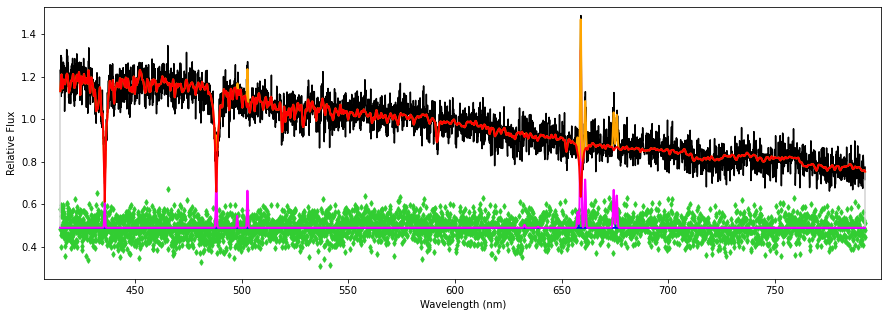

In [17]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, lam=lam, lam_temp=miles.lam_temp,
          reg_dim=reg_dim, component=component, gas_component=gas_component,
          reddening=0, gas_reddening=0, gas_names=gas_names)
plt.figure(figsize=(15, 5))
pp.plot()

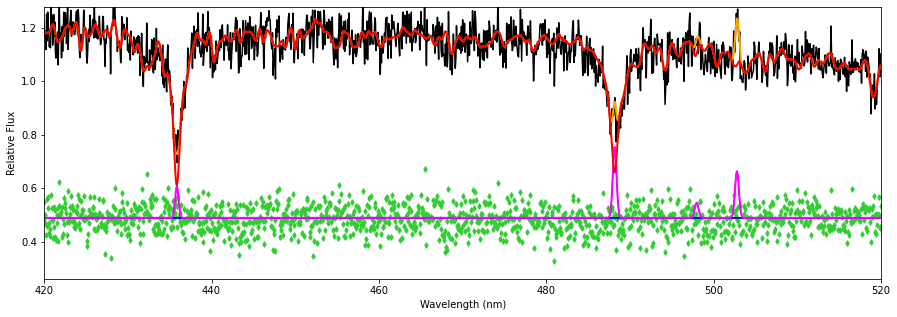

In [18]:
plt.figure(figsize=(15, 5))
pp.plot(gas_clip=1)
plt.xlim([420, 520]);

IMPORTANT: As the templates have larger instrumental dispersion than the galaxy spectrum, and for this reason it was not possible to match the resolutions of the templates before the fit, I now need to correct the fitted sigma by the quadratic differences in instrumental resolutions. In this case the correction is negligible, but in general it cannot be ignored.
<br/>

$\sigma_{\rm obs}^2=\sigma_\star^2 + \sigma_{\rm inst}^2$

In [19]:
lam_med = np.median(lam)  # Angstrom
sigma_gal = c*FWHM_gal/lam_med/2.355  # in km/s
sigma_temp = c*FWHM_temp/lam_med/2.355
sigma_obs = pp.sol[0][1]   # sigma is second element of first kinematic component
sigma = np.sqrt(sigma_obs**2 + sigma_temp**2 - sigma_gal**2)
print(f"sigma stars corrected: {sigma:.0f} km/s")

sigma stars corrected: 135 km/s


Uncertainties on stellar kinematics.
More accurate ones can be obtained with bootstrapping.

In [20]:
errors = pp.error[0]*np.sqrt(pp.chi2)      # assume the fit is good
print("Formal errors:")
print("   dV   dsigma")
print("".join("%6.2g" % f for f in errors))

Formal errors:
   dV   dsigma
   6.9   8.6


An improved estimate of the best-fitting redshift is given by the following lines (equation 8 of [Cappellari 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C))

In [21]:
vcosm = c*np.log(1 + z)                 # This is the initial redshift estimate
vpec = pp.sol[0][0]                        # This is the fitted residual velocity
vtot = vcosm + vpec                     # I add the two velocities before computing z
print(f"Best-fitting redshift z = {np.exp(vtot/c) - 1:#.6f} "
      f"+/- {np.exp(vtot/c)*errors[0]/c:#.2g}")  # error propagation

Best-fitting redshift z = 3.016669 +/- 9.2e-05


# Include the photometric measurements in the fit

## Observed galaxy photometric fluxes

Mean galaxy fluxes in the photometric bands `[i, z, J, H, K]`. Bluer bands fall outside the range of the E-MILES templates.
They are normalized like the galaxy spectrum

In [22]:
phot_galaxy = np.array([0.51, 0.44, 0.49, 1.1, 1.0])   # fluxes
phot_noise = phot_galaxy*0.01   # 1sigma uncertainties

## Setup photometric templates

To compute the photometric prediction I need to give a redshift estimate. In this way the predictions are computed on the redshifted templates.

In [23]:
bands = ['i', 'z', 'J', 'H', 'K']
phot_lam, phot_templates = np.empty((2, len(bands), miles.n_ages, miles.n_metal))
for j, band in enumerate(bands):
    phot_lam[j], phot_templates[j] = miles.photometry_from_spectra(band, redshift=3.01650)
phot = {"templates": phot_templates, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot_lam}

## Start pPXF fit

In [24]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=-1, lam=lam, lam_temp=miles.lam_temp, regul=10,
          reg_dim=reg_dim, component=component, gas_component=gas_component, gas_names=gas_names,
          reddening=0, gas_reddening=0, phot=phot)

 Best Fit:       Vel     sigma
 comp.  0:      1248       129
 comp.  1:      1244       125
Stars Reddening E(B-V): 0.184
Gas Reddening E(B-V): 0.291
chi2/DOF: 0.9577; DOF: 4119; degree = -1; mdegree = 0
Photometry chi2/n_bands: 5.333; n_bands: 5
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 36/102
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Balmer      8.689      0.22    1244   125
Comp:  1             [SII]6716      1.260      0.16    1244   125
Comp:  1             [SII]6731      1.071      0.16    1244   125
Comp:  1          [OIII]5007_d      1.694      0.20    1244   125
Comp:  1            [OI]6300_d     0.1419      0.20    1244   125
Comp:  1           [NII]6583_d      2.116      0.20    1244   125
------------------------------------------

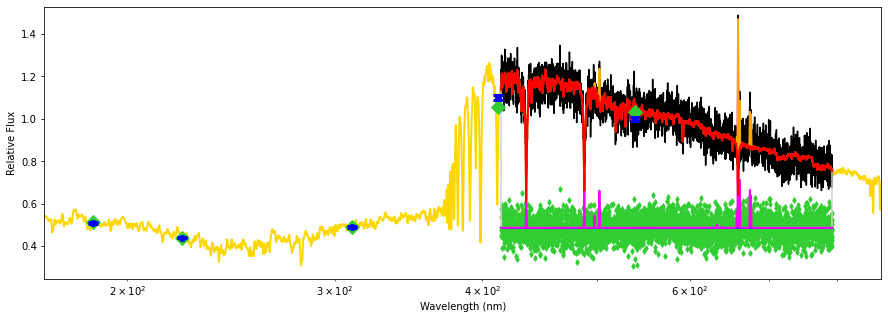

In [25]:
plt.figure(figsize=(15, 5))
pp.plot()

## Plot of the stellar population distribution

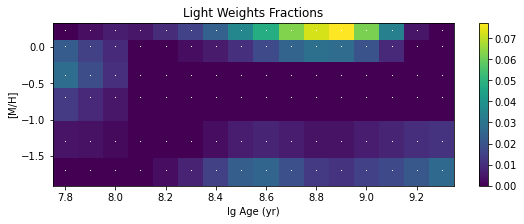

In [26]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions

plt.figure(figsize=(9,3))
miles.plot(light_weights)
plt.title("Light Weights Fractions");